In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D,Dropout,Flatten,Dense,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import glob

In [ ]:
# ap=argparse.ArgumentParser()
# # The path to the input dataset of faces and and faces with masks
# ap.add_argument("-d","--dataset",required=True,help="path to input dataset")
# # The path to your output training history plot, which will be generated using matplotlib
# ap.add_argument("-p","--plot",type=str,default="plot.png",help="path to output loss/accuracy plot")
# # The path to the resulting serialized face mask classification model
# ap.add_argument("-m","--model",type=str,default="mask_detector.model",help="path to output face mask detector model")
# args=vars(ap.parse_args())

In [ ]:
INIT_LR=1e-4
EPOCHS=20
BS=32

In [ ]:
path='/content/drive/My Drive/Projects/FaceMask detection/dataset'

In [ ]:
image=img_to_array(load_img('/content/drive/My Drive/Projects/FaceMask detection/dataset/with_mask/0-with-mask.jpg'))
image.shape

(350, 525, 3)

In [ ]:
imagePaths=glob.glob(path+'/*')  #args["dataset"]
imagePaths
data=[]
labels=[]

for imagePath in imagePaths:
  for imagep in glob.glob(imagePath+'/*.jpg'): 
  #load the input image and corresp label 
    image=load_img(imagep,target_size=(224,224))
    image=img_to_array(image)
    image=preprocess_input(image)
    label=imagep.split('/')[-2]
  #update data and label list
    data.append(image)
    labels.append(label)

# convert the data and labels to NumPy arrays
data1 = np.array(data, dtype="float32")
labels1 = np.array(labels)

In [ ]:
#perform one hot encoding on the labels
lb=LabelBinarizer()
labels=lb.fit_transform(labels1)  #REQUIRES NUMPY ARRAY
labels=to_categorical(labels)

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX,testX,trainY,testY)=train_test_split(data1,labels,test_size=0.2,stratify=labels,random_state=42) #TRY OTHER RANDOM_STATES

#construct training image generator for data augmentation
aug=ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel=MobileNetV2(weights="imagenet",include_top=False,input_tensor=Input(shape=(224,224,3)))

#construct head of model that will be placed at top of base model
headModel=baseModel.output
headModel=AveragePooling2D(pool_size=(7,7))(headModel)
headModel=Flatten(name="flatten")(headModel)
headModel=Dense(128,activation="relu")(headModel)
headModel=Dropout(0.5)(headModel)
headModel=Dense(2,activation="softmax")(headModel)

#place head of FC model on top of base model to make actual model
model=Model(inputs=baseModel.input,outputs=headModel)


#loop over all layers in base model and freeze them so they will not get modifies during first training process
for layer in baseModel.layers:
    layer.trainable=False

[FOR BETTER UNDERSTANDING OF CONV2D, DEPTHWISECONV2D, POINTWISECONV2D,
 SEPERABLECONV2D](https://youtu.be/T7o3xvJLuHk)

In [ ]:
opt=Adam(lr=INIT_LR,decay=INIT_LR/EPOCHS)

# https://gist.github.com/koshian2/4a8b27a1368db17d3cd6228ff01c876f    --REFER THIS LINK FOR IMPLEMENTING SGDR IN KERAS
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

#train head of model
Head_model=model.fit(
    aug.flow(trainX,trainY,batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX,testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)


Epoch 1/20
34/34 [==============================] - 11s 336ms/step - loss: 0.6529 - accuracy: 0.6760 - val_loss: 0.1645 - val_accuracy: 0.9746
Epoch 2/20
34/34 [==============================] - 10s 307ms/step - loss: 0.1630 - accuracy: 0.9476 - val_loss: 0.0583 - val_accuracy: 0.9928
Epoch 3/20
34/34 [==============================] - 10s 308ms/step - loss: 0.0955 - accuracy: 0.9738 - val_loss: 0.0382 - val_accuracy: 0.9928
Epoch 4/20
34/34 [==============================] - 11s 315ms/step - loss: 0.0632 - accuracy: 0.9869 - val_loss: 0.0285 - val_accuracy: 0.9964
Epoch 5/20
34/34 [==============================] - 10s 307ms/step - loss: 0.0538 - accuracy: 0.9841 - val_loss: 0.0242 - val_accuracy: 0.9928
Epoch 6/20
34/34 [==============================] - 11s 316ms/step - loss: 0.0518 - accuracy: 0.9853 - val_loss: 0.0193 - val_accuracy: 0.9964
Epoch 7/20
34/34 [==============================] - 10s 307ms/step - loss: 0.0377 - accuracy: 0.9906 - val_loss: 0.0176 - val_accuracy: 0.9928

In [ ]:
# make predictions on the testing set
predIdxs=model.predict(testX,batch_size=BS)

# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs=np.argmax(predIdxs,axis=1)

#show nicely formatted classification report
print(classification_report(testY.argmax(axis=1),predIdxs,target_names=lb.classes_))

#serialize model to disk
model.save('/content/drive/My Drive/Projects/FaceMask detection/mask_detection_model_new',save_format='h5')    # args["model"]

              precision    recall  f1-score   support

   with_mask       0.99      1.00      0.99       138
without_mask       1.00      0.99      0.99       138

    accuracy                           0.99       276
   macro avg       0.99      0.99      0.99       276
weighted avg       0.99      0.99      0.99       276



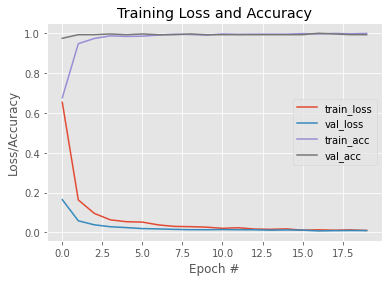

In [ ]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), Head_model.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), Head_model.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), Head_model.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), Head_model.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="best")
plt.savefig('/content/drive/My Drive/Projects/FaceMask detection/plot')

WHEN WRITING CODE AND DEPLOYING IT IN DIFFERENT VERSIONS OF TENSORFLOW BELOW CODE IS HELPFUL

**save_from tensorflow=2.0.0**

1.model.save_weights("weights_only.h5")

2.json_config = model.to_json()

  with open('model_config.json', 'w') as json_file:

    json_file.write(json_config)

**load_model in tensorflow=1.14.0  (weights only sufficient)**

1.first remove rag='false' from model_config.json by ctrl+f

2.write folowing code:

 `with open('/home/neha/Downloads/Projects/face-mask-detector-master/model_config.json') as json_file:`

	  `json_config = json_file.read()`

  `new_model = tensorflow.keras.models.model_from_json(json_config)`

  `new_model.load_weights('/home/neha/Downloads/Projects/face-mask-detector-master/weights_only.h5')`

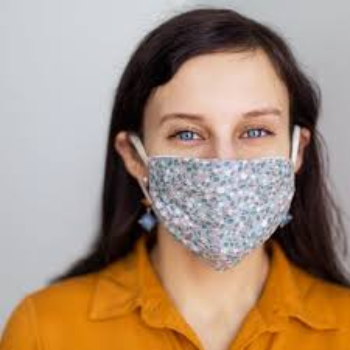

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import load_model

# model.save_weights("weights_only_new.h5")
# json_config = model.to_json()
# with open('model_config.json', 'w') as json_file:
#   json_file.write(json_config)

#No need of above steps as we r loading in same version 
model=load_model('/content/drive/My Drive/Projects/FaceMask detection/mask_detection_model_new')
face_cascade = cv2.CascadeClassifier('/content/drive/My Drive/Projects/FaceMask detection/haarcascade_frontalface_default.xml')

face=cv2.imread('/content/drive/My Drive/Projects/FaceMask detection/img1.jpeg')
face=cv2.resize(face,(350,350))
gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 1,flags=0,minSize=(65,65))
cv2_imshow(face)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


Mask


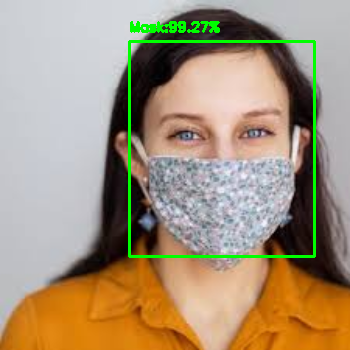

In [ ]:
if faces==():
  input_face=face
  input_face=cv2.resize(input_face,(224,224))
  input_face=img_to_array(input_face)
  input_face=preprocess_input(input_face)
  input_face=np.expand_dims(input_face,axis=0)
  (mask, withoutMask) = model.predict(input_face)[0]
  label="Mask" if mask>withoutMask else "No Mask"
  print(label+' is detected with {} accuracy'.format(max(mask,withoutMask)*100))

else:
  for (x,y,w,h) in faces:
    input_face=face[y-20:y+h+10,x:x+w]
    input_face=cv2.resize(input_face,(224,224))
    input_face=img_to_array(input_face)
    input_face=preprocess_input(input_face)
    input_face=np.expand_dims(input_face,axis=0)
    (mask, withoutMask) = model.predict(input_face)[0]
    label="Mask" if mask>withoutMask else "No Mask"
    print(label)
    color=(0,255,0) if label =="Mask" else (0,0,255)
    label="{}:{:.2f}%".format(label,max(mask,withoutMask)*100)
    cv2.putText(face,label,(x,y-30),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
    cv2.rectangle(face,(x,y-20),(x+w,y+h+10),color,2)

cv2_imshow(face)

[faceMask detection on live feed](https://drive.google.com/file/d/1wasTJE8agMuQ3arY_YKGdrcz2L-YZjcY/view?usp=sharing)

In [ ]:
#STANDARD GRADIENT DESCENT WITH RESTARTS USING KERAS

# lr=1e-4
# EPOCHS=100

# class SGDRScheduler(Callback):
#   def __init__(self,min_lr,max_lr,steps_per_epoch,lr_decay=0.9,cycle_length=5,mult_factor=2):
#     self.min_lr=min_lr
#     self.max_lr=max_lr
#     self.lr_decay=lr_decay
#     self.batch_since_restart=0
#     self.next_restart=cycle_length
#     self.steps_per_epoch=steps_per_epoch
#     self.cycle_length=cycle_length
#     self.mult_factor=mult_factor
#     self.history={}

#   def clr(self):
#     #calculate learning rate
#     fraction_to_restart=self.batch_since_restart/(self.steps_per_epoch * self.cycle_length)
#     lr=self.min_lr+0.5*(self.max_lr - self.min_lr)*(1+np.cos(fraction_to_restart*np.pi))
#     return lr

#   def on_train_begin(self,logs={}):
#     #Initialize the learning rate to maximum value at starting of training
#     K.set_value(self.model.optimizer.lr,self.max_lr)

#   def on_batch_end(self,batch,logs={}):
#     #record previous batch statistics and update learning rate
#     self.history.setdefault('lr',[]).append(K.get_value(self.model.optimizer.lr))
#     for k,v in logs.items():
#       self.history.setdefault(k,[]).append(v)

#     self.batch_since_restart+=1
#     K.set_value(self.model.optimizer.lr,self.clr())

#   def on_epoch_end(self,epoch,logs={}):
#     #check for end of current cycle,apply restarts when necessary
#     if epoch+1 ==self.next_restart:
#       self.batch_since_restart=0
#       self.cycle_length=np.ceil(self.cycle_length * self.mult_factor)
#       self.next_restart += self.cycle_length
#       self.max_lr *= self.lr_decay
#       self.best_weights = self.model.get_weights()

#   def on_train_end(self, logs={}):
#         #Set weights to the values from the end of the most recent cycle for best performance.'''
#     self.model.set_weights(self.best_weights) 


# model.compile(optimizer=SGD(lr=lr, momentum=0.9), loss="binary_crossentropy", metrics=["accuracy"])
# # opt=Adam(lr=lr,decay=lr/EPOCHS)
# # model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
# sgdr=SGDRScheduler(1e-2,1e-5,np.ceil(EPOCHS/BS))
# Head_model=model.fit(
#     aug.flow(trainX,trainY,batch_size=BS),
#     steps_per_epoch=len(trainX) // BS,
#     validation_data=(testX,testY),
#     validation_steps=len(testX) // BS,
#     epochs=EPOCHS,
#     callbacks=[sgdr])

In [ ]:
#MOBILENETV2 ARCHITECTURE

# from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dropout
# from keras.layers import Activation, BatchNormalization, Add, Reshape, DepthwiseConv2D

# def relu6(x):
#     return K.relu(x, max_value=6.0)

# def _conv_block(inputs, filters, kernel, strides):
#     channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
#     x = Conv2D(filters, kernel, padding='same', strides=strides)(inputs)
#     x = BatchNormalization(axis=-1)(x)
#     return Activation(relu6)(x)

# def _bottleneck(inputs, filters, kernel, t ,s, r=False):
#     tchannel = K.int_shape(inputs)[-1] * t
#     x = _conv_block(inputs, tchannel, (1, 1), (1, 1))
#     x = DepthwiseConv2D(kernel, strides=(s, s), depth_multiplier=1, padding='same')(x)
#     x = BatchNormalization(axis=-1)(x)
#     x = Activation(relu6)(x)
#     x = Conv2D(filters, (1, 1), strides=(1, 1), padding='same')(x)
#     x = BatchNormalization(axis=-1)(x)
#     if r:
#         x = Add()([x, inputs])
#     return x

# def _inverted_residual_block(inputs, filters, kernel, t, strides, n):
#     x = _bottleneck(inputs, filters, kernel, t, strides)
#     for i in range(1, n):
#         x = _bottleneck(x, filters, kernel, t, 1, True)
#     return x

# def maskDetection_model(input_shape):
#   inputs=Input(input_shape)
#   x=ZeroPadding2D(padding=(1, 1))(inputs)
#   x = _conv_block(inputs, 32, (3, 3), strides=(2, 2))
#   x = _inverted_residual_block(x, 16, (3, 3), t=1, strides=1, n=1)
#   x = _inverted_residual_block(x, 24, (3, 3), t=6, strides=2, n=2)
#   x = _inverted_residual_block(x, 32, (3, 3), t=6, strides=2, n=3)
#   x = _inverted_residual_block(x, 64, (3, 3), t=6, strides=2, n=4)
#   x = _inverted_residual_block(x, 96, (3, 3), t=6, strides=1, n=3)
#   x = _inverted_residual_block(x, 160, (3, 3), t=6,strides=2, n=3)
#   x = _inverted_residual_block(x, 320, (3, 3), t=6, strides=1, n=1)
#   x = _conv_block(x, 1280, (1, 1), strides=(1, 1))
#   x = GlobalAveragePooling2D()(x)
#   x = Reshape((1, 1, 1280))(x)
#   x = Dropout(0.3, name='Dropout')(x)
#   x = Conv2D(2, (1, 1), padding='same')(x)

#   x = Activation('softmax', name='softmax')(x)
#   output = Reshape((2,))(x)

#   model = Model(inputs, output)
#   return model

# model=maskDetection_model((224,224,3))